In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm.notebook import tqdm, trange
import os
import threading 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

In [2]:
# hyperparameters
n = 3
with_action = False

In [6]:
train_x, train_y = list(), list()
val_x, val_y = list(), list()
files = os.listdir('1st_version_data')
# np.random.shuffle(files)
progress = tqdm(total=len(files))
for file_idx in range(len(files)):
    df = pd.read_excel(os.path.join('1st_version_data', files[file_idx]))
    df = np.array(df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)).astype(np.float32)

    for idx in range(len(df)):

        if idx+n > len(df):
            break

        data = list()
        for i in range(n):
            if with_action or i == n-1:
                data += list(df[idx+i])
            else:
                data += list(df[idx+i][:-1])

        if file_idx < len(files)*0.8:
            train_x.append(data[:-1])
            train_y.append(data[-1])
        else:
            val_x.append(data[:-1])
            val_y.append(data[-1])

    progress.update(1)

  0%|          | 0/638 [00:00<?, ?it/s]

In [8]:
train_x = np.array(train_x).astype(np.float32)
train_y = np.array(train_y).astype(np.float32)
val_x = np.array(val_x).astype(np.float32)
val_y = np.array(val_y).astype(np.float32)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(123177, 15) (123177,)
(30053, 15) (30053,)


In [9]:
class myDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]
        return x, y
    
batch_size = 128
train_set = myDataset(train_x, train_y)
val_set = myDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
feature_num = 6*n-1 if with_action else 5*n

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(feature_num, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        return self.dnn(x)
    
model = Classifier().cuda()

summary(model, (feature_num, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          16,384
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 1024]       1,049,600
              ReLU-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
              ReLU-6                 [-1, 1024]               0
            Linear-7                    [-1, 1]           1,025
Total params: 2,116,609
Trainable params: 2,116,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 8.07
Estimated Total Size (MB): 8.12
----------------------------------------------------------------


In [11]:
# model = Classifier().cuda()

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-2)
num_epoch = 50

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() 
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred.reshape(-1, 1), data[1].reshape(-1, 1).cuda())
        batch_loss.backward() 
        optimizer.step()

        train_loss += batch_loss.item() * len(train_pred)
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred.reshape(-1, 1), data[1].reshape(-1, 1).cuda())

            val_loss += batch_loss.item() * len(val_pred)

    print('[%03d/%03d] %2.2f sec(s) Train Loss: %3.6f | Val loss: %3.6f' % \
        (epoch + 1, num_epoch, time.time()-epoch_start_time, \
         train_loss/train_set.__len__(), val_loss/val_set.__len__()))


[001/050] 4.28 sec(s) Train Loss: 1.056497 | Val loss: 0.405567
[002/050] 3.82 sec(s) Train Loss: 0.435339 | Val loss: 0.420088
[003/050] 3.91 sec(s) Train Loss: 0.390432 | Val loss: 0.426219
[004/050] 4.43 sec(s) Train Loss: 0.382112 | Val loss: 0.396994
[005/050] 3.98 sec(s) Train Loss: 0.382765 | Val loss: 0.402131
[006/050] 3.78 sec(s) Train Loss: 0.382223 | Val loss: 0.387634
[007/050] 4.03 sec(s) Train Loss: 0.393888 | Val loss: 0.391234
[008/050] 4.01 sec(s) Train Loss: 0.382563 | Val loss: 0.404474
[009/050] 4.12 sec(s) Train Loss: 0.383719 | Val loss: 0.394757
[010/050] 4.30 sec(s) Train Loss: 0.382994 | Val loss: 0.390219
[011/050] 4.24 sec(s) Train Loss: 0.381553 | Val loss: 0.406615
[012/050] 4.70 sec(s) Train Loss: 0.377581 | Val loss: 0.390130
[013/050] 4.33 sec(s) Train Loss: 0.378038 | Val loss: 0.393556
[014/050] 4.04 sec(s) Train Loss: 0.376302 | Val loss: 0.398943
[015/050] 4.00 sec(s) Train Loss: 0.374983 | Val loss: 0.392616
[016/050] 3.93 sec(s) Train Loss: 0.3742

0


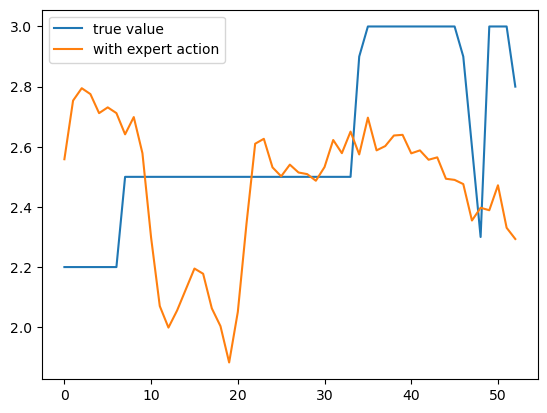

1


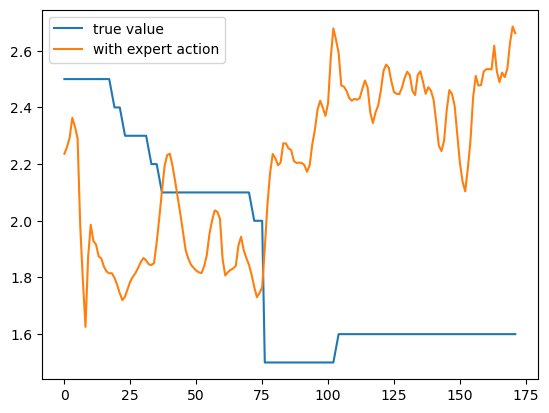

2


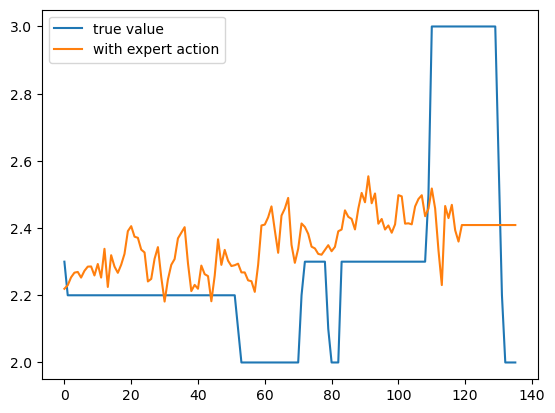

3


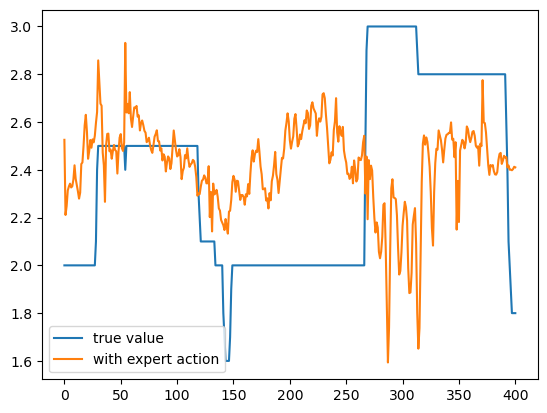

4


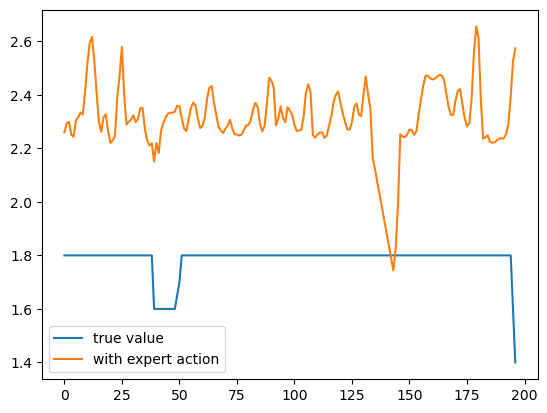

In [15]:
for idx in range(5):
    # file_idx = np.random.randint(math.ceil(len(files)*0.8), len(files))
    file_idx = idx
    print(file_idx)
    df = pd.read_excel(os.path.join('1st_version_data', files[file_idx]))
    df = np.array(df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)).astype(np.float32)
        
    test_x, test_y = list(), list()
    for idx in range(len(df)):

        if idx+n > len(df):
            break

        data = list()
        for i in range(n):
            if with_action or i == n-1:
                data += list(df[idx+i])
            else:
                data += list(df[idx+i][:-1])
            
        test_x.append(data[:-1])
        test_y.append(data[-1])
    
    test_pred = model(torch.tensor(np.array(test_x).astype(np.float32)).cuda())
    
    plt.figure()
    plt.plot(test_y, label = 'true value')  
    plt.plot(test_pred.cpu().detach().numpy(), label = 'with expert action')
    
    if with_action:
        test_model_pred = list()
        for idx in range(len(df)):

            if idx+n > len(df):
                break

            data = list()
            for i in range(n):
                data += list(df[idx+i][:-1])
                
                if i == n-1:
                    continue
                
                if idx+i-(n-1) >= len(test_model_pred) or idx+i-(n-1) < 0:
                    data += [df[idx+1][-1]]
                else:
                    data += [test_model_pred[idx+i-(n-1)]]
            test_model_pred.append(model(torch.tensor(np.array(data).astype(np.float32)).cuda()).item())
        plt.plot(test_model_pred, label = 'with model action')
        
    plt.legend()
    plt.show()